In [72]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from unidecode import unidecode
import re
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from hmmlearn import hmm


In [30]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
#
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacks\AppData\Ro

In [5]:
# Step 1: Download and Preprocess the Novels from Project Gutenberg
def download_novel(url):
    response = requests.get(url)
    text = BeautifulSoup(response.text, 'html.parser').get_text()
    return text

In [47]:

# List of URLs for multiple Maurice Leblanc novels
urls = [
    "https://www.gutenberg.org/cache/epub/34758/pg34758.txt",   # 813
    "https://www.gutenberg.org/cache/epub/6133/pg6133.txt",     # Arsène Lupin, Gentleman Burglar
    "https://www.gutenberg.org/cache/epub/40203/pg40203.txt",   # Arsène Lupin vs. Herlock Sholmes
    "https://www.gutenberg.org/cache/epub/1563/pg1563.txt",     # The Crystal Stopper
    "https://www.gutenberg.org/cache/epub/4014/pg4014.txt",     # The Hollow Needle    
    "https://www.gutenberg.org/cache/epub/34795/pg34795.txt",   # The Golden Triangle                                   
    "https://www.gutenberg.org/cache/epub/28093/pg28093.txt",   # The Confessions of Arsène Lupin                             
    "https://www.gutenberg.org/cache/epub/7896/pg7896.txt",     # The Eight Strokes of the Clock                              
    "https://www.gutenberg.org/cache/epub/34939/pg34939.txt",   # The Secret of Sarek                                                             
    "https://www.gutenberg.org/cache/epub/13058/pg13058.txt",   # The Teeth of the Tiger                                             
    # Add more URLs if additional works become available
]

In [77]:

# Define characters for analysis
characters = [
    "alice", "altenheim", "beautrelet", "bresson", "charolais", "coralie", 
    "daubrecq", "daspry", "detinan", "astrignac", "elizabeth", "filleul", 
    "francois", "ganimard", "gilbert", "guerchard", "jacqueline", "kesselbach", 
    "kercoz", "lenormand", "lupin", "kesselbach", "patrice", "raymonde", 
    "sabron", "sernine", "sholmes", "vaucheray", "velmont", "veronique", "verot"
]

In [78]:

crime_keywords = [
    "murder", "crime", "theft", "death", "kill", "steal", 
    "assault", "weapon", "poison", "trap", "plot", 
    "attack", "suspect", "clue", "threat", "danger", 
    "escape", "robbery", "kidnap", "pursuit", "revenge", 
    "fraud", "guilty", "innocent", "conspiracy", "arrest", 
    "heist", "scandal", "victim", "witness"
]

In [80]:

# Step 2: Normalize and Tokenize the Text
def preprocess_text(text):

    # Transliterate to ASCII (remove accents)
    text = unidecode(text)
    
    # lowercase, keep only letters and spaces, and tokenize
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)

    # remove stopwords (e.g. 'the', 'a', 'an')
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [82]:

# Step 3: Character-Based Features with Adjusted Window for Co-Occurrences
def character_features(tokens, characters, window=100):
    character_first_mentions = {}
    co_occurrences = defaultdict(Counter)
    character_sentiments = defaultdict(list)
    
    for i, token in enumerate(tokens):
        if token in characters:
            if token not in character_first_mentions:
                character_first_mentions[token] = i
            
            # Context window for co-occurrence and sentiment
            start, end = max(0, i - window), min(len(tokens), i + window)
            context = " ".join(tokens[start:end])
            sentiment = sia.polarity_scores(context)['compound']
            character_sentiments[token].append(sentiment)
            
            nearby_characters = set(tokens[start:end]).intersection(characters)
            for other_character in nearby_characters:
                if other_character != token:
                    co_occurrences[token][other_character] += 1
    
    return character_first_mentions, co_occurrences, character_sentiments

In [83]:
# Step 4: Event-Based Features
def event_features(tokens, crime_keywords, adjectives_only=True):
    crime_positions = [i for i, token in enumerate(tokens) if token in crime_keywords]
    first_crime_position = crime_positions[0] if crime_positions else None
    crime_keyword_counts = Counter([token for token in tokens if token in crime_keywords])
    
    crime_adjectives = []
    if adjectives_only:
        for i in crime_positions:
            window_tokens = tokens[max(0, i-10):i+10]
            pos_tags = nltk.pos_tag(window_tokens)
            crime_adjectives.extend([word for word, tag in pos_tags if tag == 'JJ'])
    
    return first_crime_position, crime_keyword_counts, crime_adjectives

In [84]:
# Crime Keyword Distribution Analysis
def crime_keyword_distribution(tokens, crime_keywords, interval=500):
    keyword_distribution = []
    for i in range(0, len(tokens), interval):
        chunk = tokens[i:i+interval]
        crime_count = sum(1 for word in chunk if word in crime_keywords)
        keyword_distribution.append(crime_count)
    
    return keyword_distribution

In [85]:
# Visualization Functions
# Function to plot the top 25 words by frequency for each novel

def plot_top_words(tokens, title=""):
    # Count the frequency of each word
    top_words = Counter(tokens).most_common(25)
    
    # # Remove common stopwords (optional for a cleaner plot)
    # stopwords = nltk.corpus.stopwords.words('english')
    # filtered_counts = {word: count for word, count in word_counts.items() if word not in stopwords}
    
    # # Get the top 25 most common words
    # top_words = Counter(filtered_counts).most_common(25)
    
    # Separate words and their frequencies for plotting
    words, frequencies = zip(*top_words)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top 25 Words by Frequency - {title}")
    plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent word at the top
    plt.show()

In [86]:
# Distribution of Crime Keywords
def plot_crime_keyword_distribution(distribution, interval=500, title=""):
    positions = [i * interval for i in range(len(distribution))]
    plt.figure(figsize=(10, 5))
    plt.plot(positions, distribution, color='purple', marker='o', linestyle='-')
    plt.xlabel("Text Position")
    plt.ylabel("Crime Keyword Frequency")
    plt.title(f"Distribution of Crime-Related Keywords - {title}")
    plt.show()

In [87]:
# Character Sentiment Progression
def plot_character_sentiments(character_sentiments, title=""):
    plt.figure(figsize=(10, 5))
    for character, sentiments in character_sentiments.items():
        plt.plot(sentiments, label=character)
    
    plt.xlabel("Appearance Index")
    plt.ylabel("Sentiment Score")
    plt.title(f"Sentiment Progression around Character Mentions - {title}")
    plt.legend()
    plt.show()

In [88]:
# Narrative Structure: Calm vs. Action intervals
def plot_narrative_structure(calm_intervals, action_intervals, title=""):
    plt.figure(figsize=(10, 5))
    plt.plot(calm_intervals, [1]*len(calm_intervals), 'go', label='Calm Scene')
    plt.plot(action_intervals, [1]*len(action_intervals), 'ro', label='Action Scene')
    plt.ylim(0, 2)
    plt.xlabel("Text Position")
    plt.ylabel("Scene Type")
    plt.title(f"Narrative Structure: Calm vs. Action Scenes - {title}")
    plt.legend()
    plt.show()

In [89]:
# Co-occurence Network Plotting
def plot_character_network(co_occurrences):
    G = nx.Graph()

    # Add nodes and edges based on co-occurrence data
    for char, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            G.add_edge(char, neighbor, weight=count**0.5)

    # Draw the graph with weighted edges
    pos = nx.spring_layout(G, k=0.5)  # Position nodes
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title("Character Co-occurrence Network")
    plt.show()


In [90]:
# Combined Co-occurrence Matrix Plotting
def plot_combined_co_occurrences(co_occurrences, characters):
    co_occurrence_matrix = np.zeros((len(characters), len(characters)))
    
    for i, char1 in enumerate(characters):
        for j, char2 in enumerate(characters):
            co_occurrence_matrix[i, j] = co_occurrences[char1][char2]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(co_occurrence_matrix, cmap="Blues", interpolation="nearest")
    plt.xticks(range(len(characters)), characters, rotation=90)
    plt.yticks(range(len(characters)), characters)
    plt.colorbar(label="Co-occurrence Frequency")
    plt.title("Combined Character Co-occurrence Matrix Across All Novels")
    plt.show()

In [91]:
# Step 5: Structural Features
def structural_features(tokens, chapter_keyword="chapter"):
    chapter_positions = [i for i, token in enumerate(tokens) if token == chapter_keyword]
    
    interval = 500
    calm_intervals, action_intervals = [], []
    
    for i in range(0, len(tokens), interval):
        chunk = tokens[i:i+interval]
        crime_count = sum(1 for word in chunk if word in crime_keywords)
        if crime_count > 5:
            action_intervals.append(i)
        else:
            calm_intervals.append(i)
    
    return chapter_positions, calm_intervals, action_intervals

In [92]:
# Define Event-Based Features for Plot Progression
def plot_progression_features(tokens, crime_keywords, interval=1000):
    # Calculate event frequency in segments for narrative progression
    event_freq = []
    for i in range(0, len(tokens), interval):
        chunk = tokens[i:i+interval]
        crime_count = sum(1 for word in chunk if word in crime_keywords)
        event_freq.append(crime_count)
    
    return np.array(event_freq).reshape(-1, 1)  # Reshape for HMM

In [93]:
# Fit Hidden Markov Model to Capture Narrative Arcs
def train_plot_progression_model(event_freq):
    # Define an HMM with a reasonable number of states (e.g., beginning, middle, end)
    model = hmm.GaussianHMM(n_components=3, n_iter=100, random_state=42)
    model.fit(event_freq)
    hidden_states = model.predict(event_freq)
    
    # Plot the hidden states to visualize narrative arcs
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(hidden_states)), hidden_states, color="blue", marker='o')
    plt.xlabel("Narrative Position (Interval)")
    plt.ylabel("Hidden State (Narrative Arc)")
    plt.title("Plot Progression Model - Narrative States Over Novel")
    plt.show()
    
    return model, hidden_states

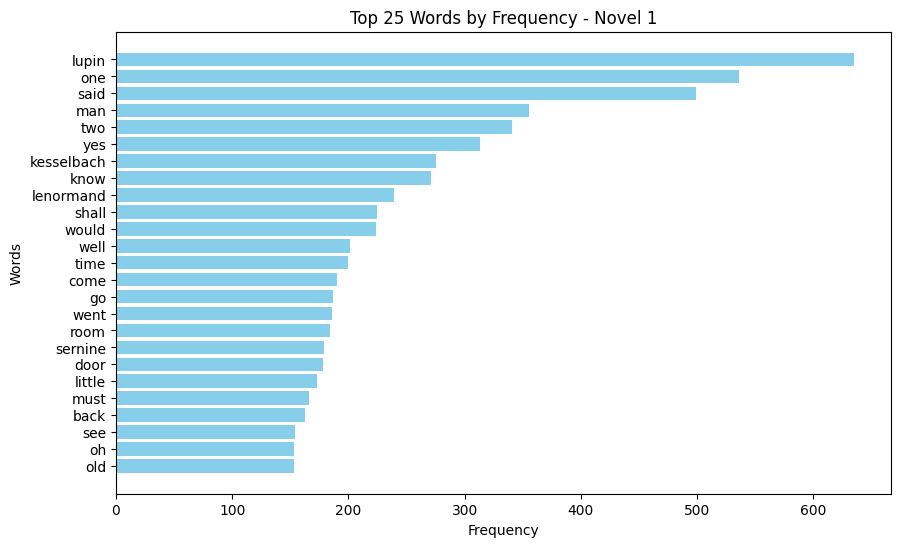

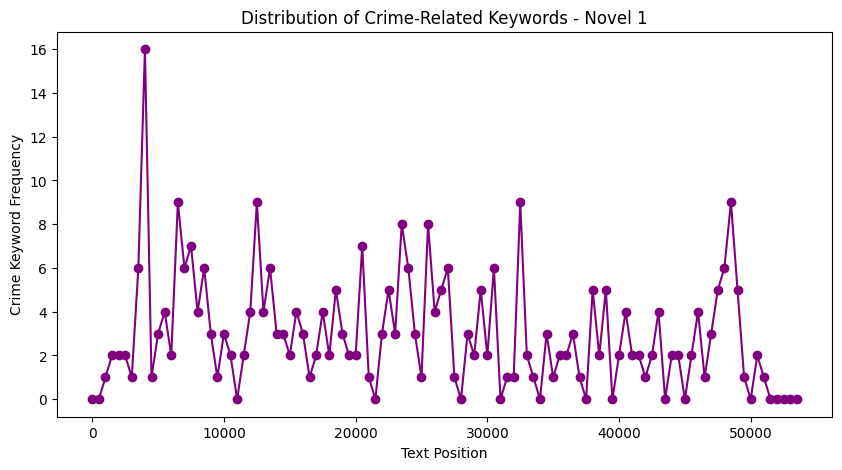

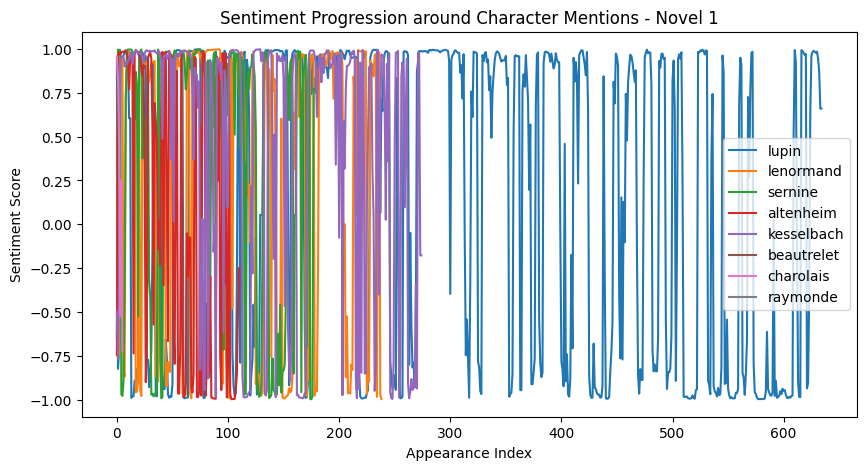

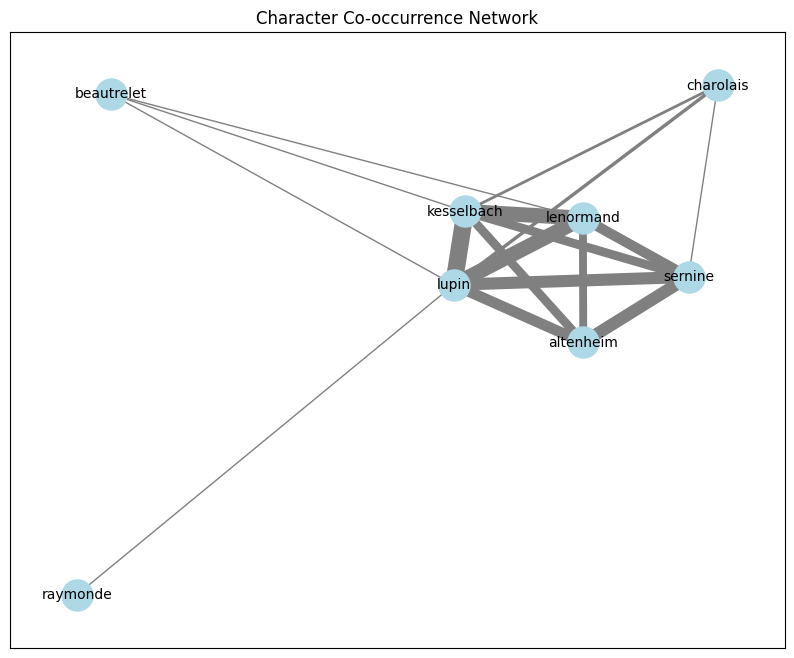

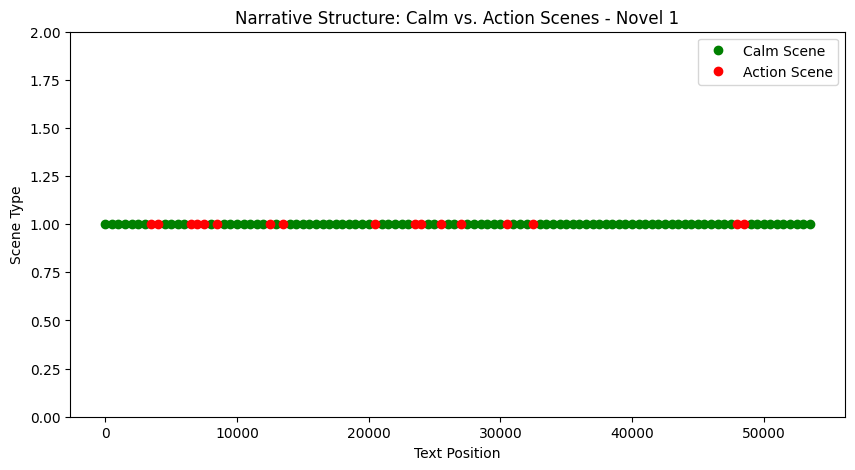

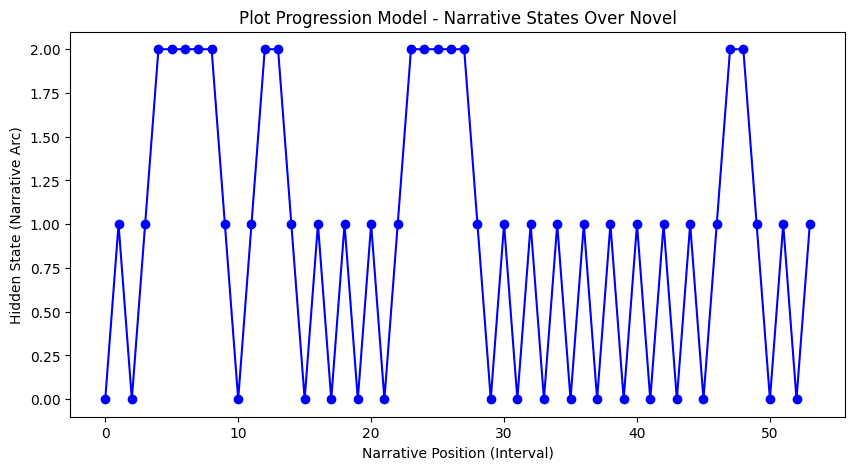

Processed and visualized data for Novel 1



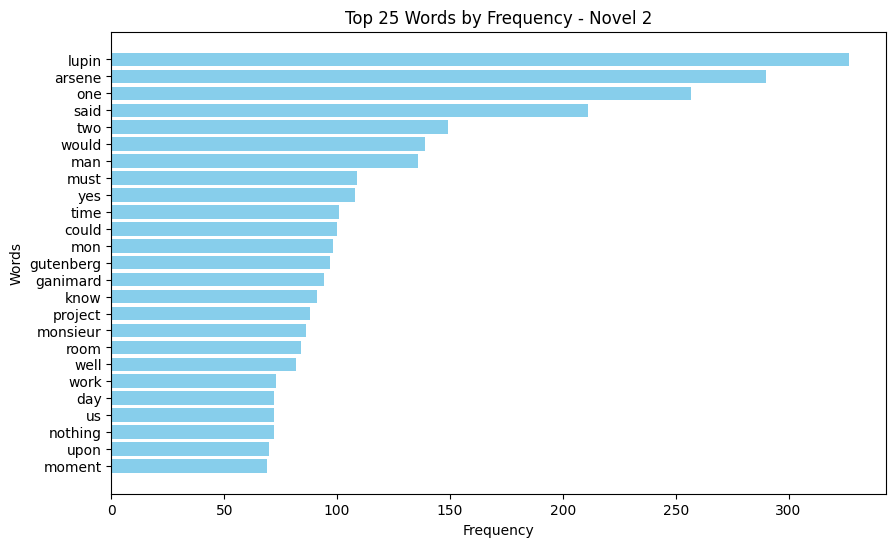

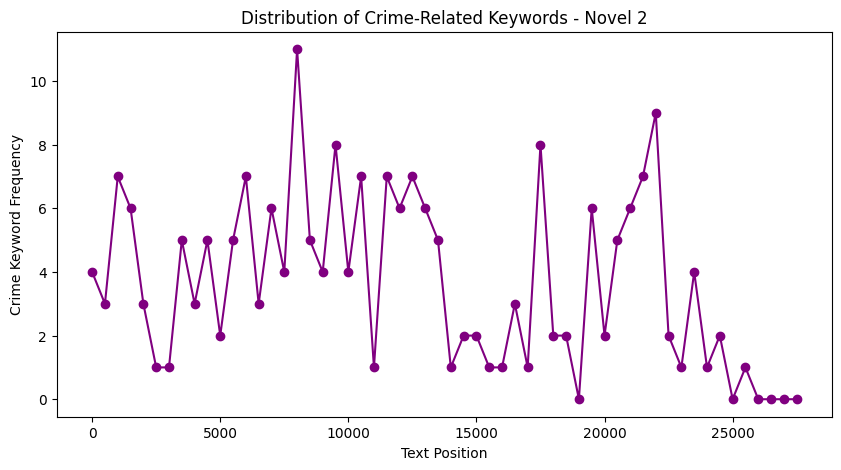

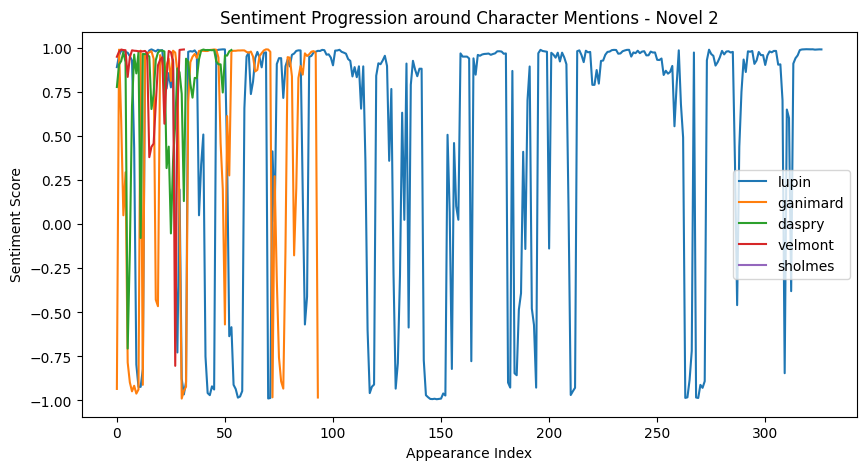

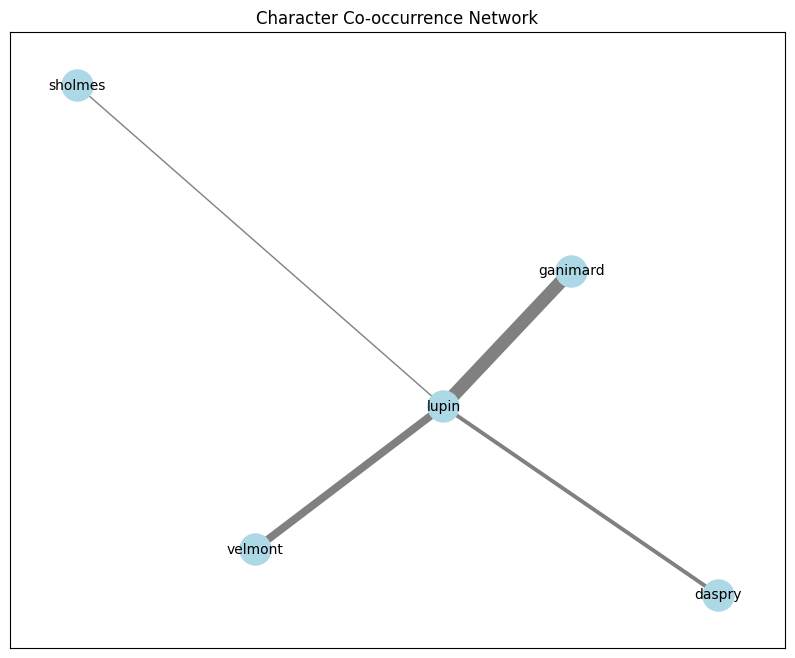

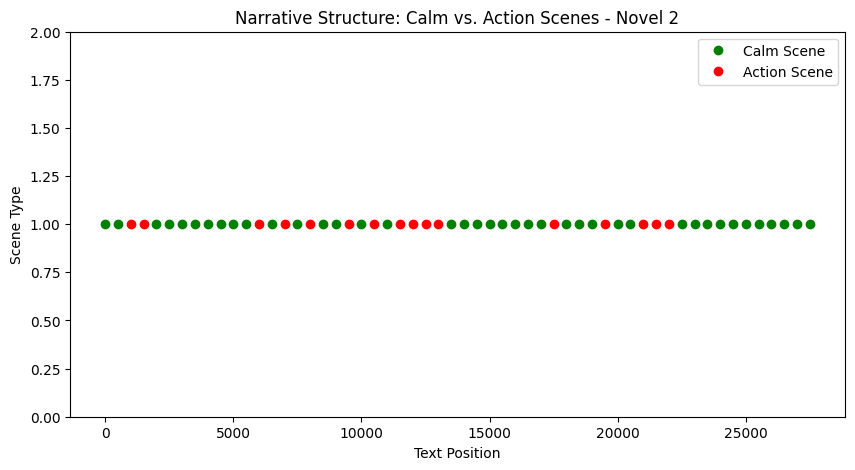

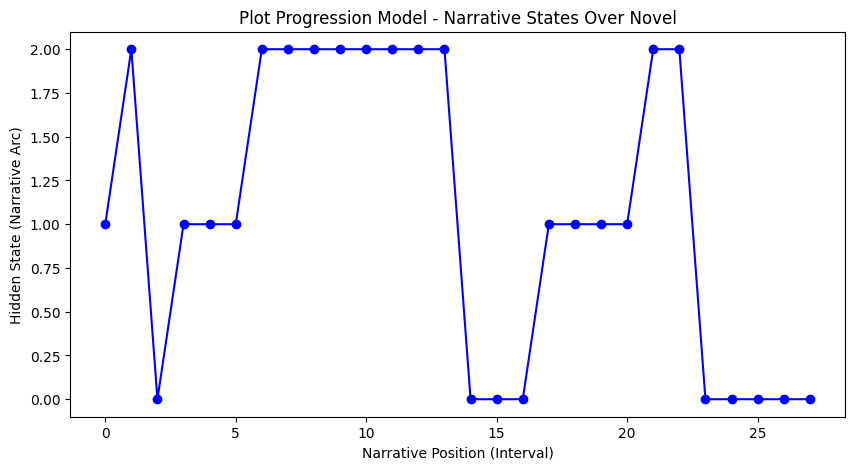

Processed and visualized data for Novel 2



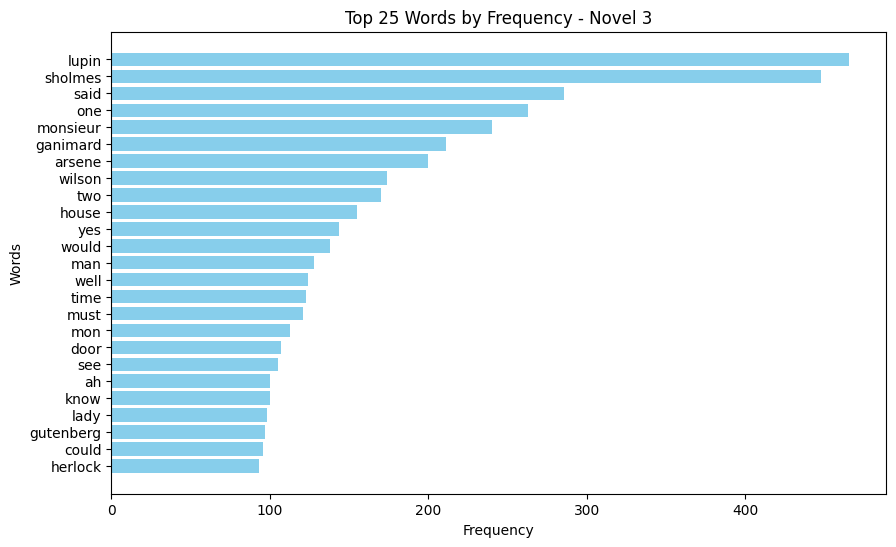

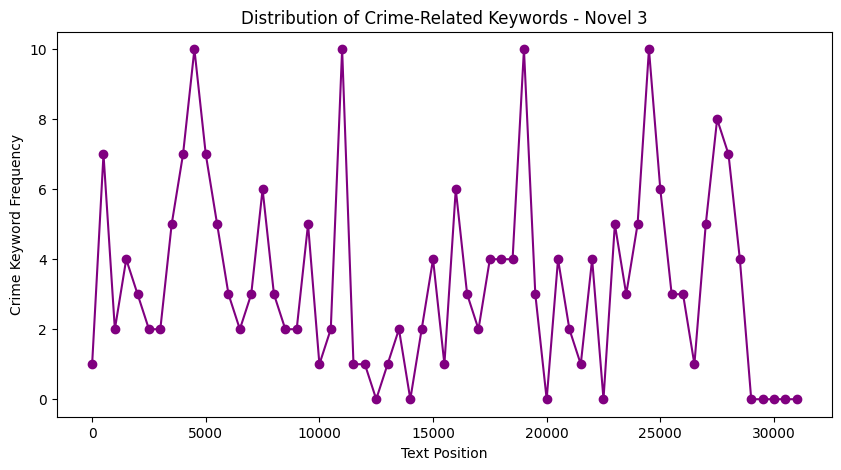

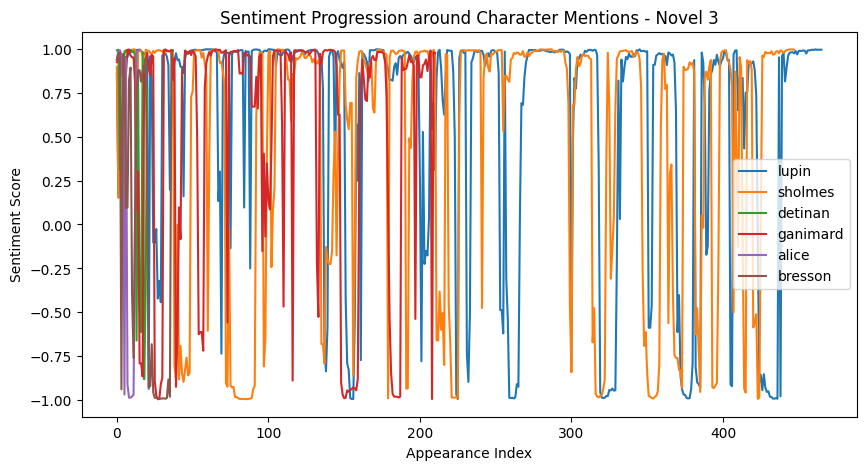

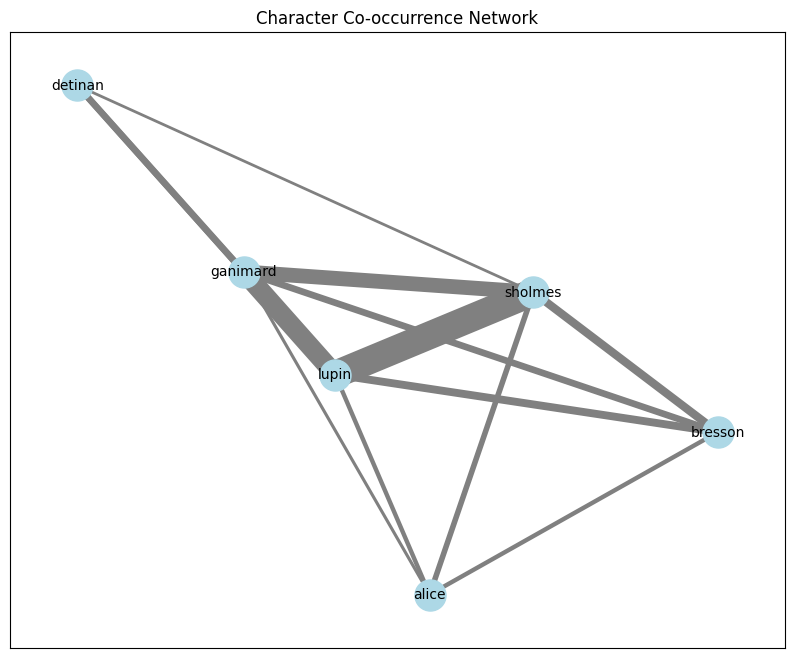

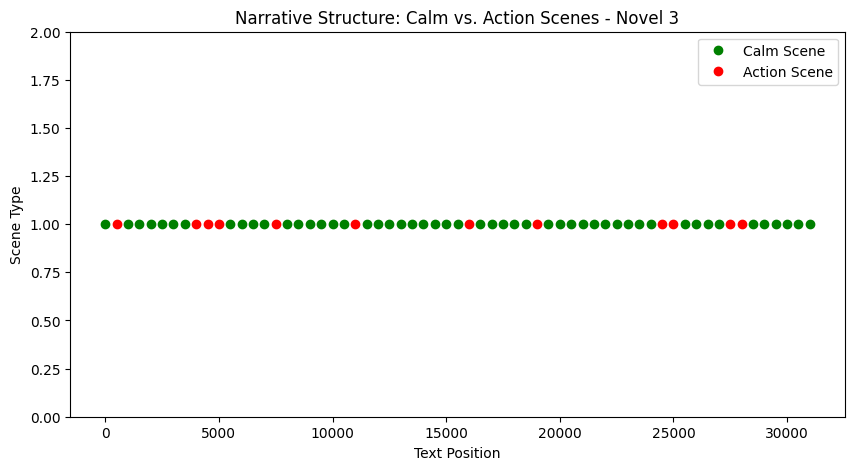

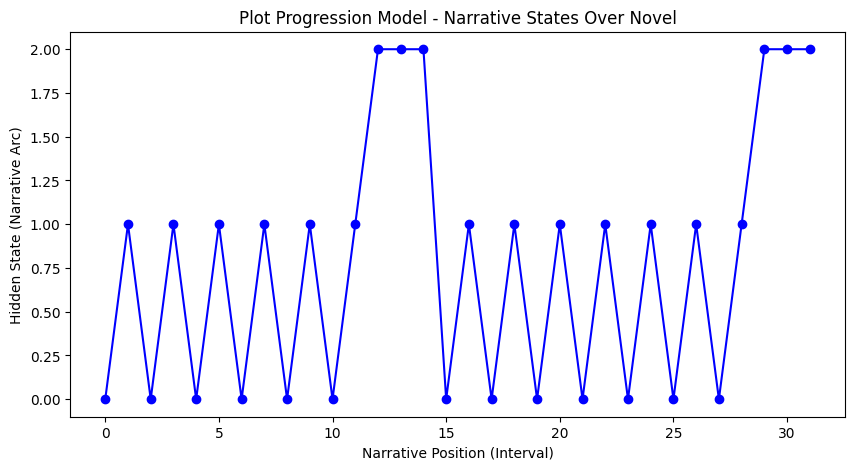

Processed and visualized data for Novel 3



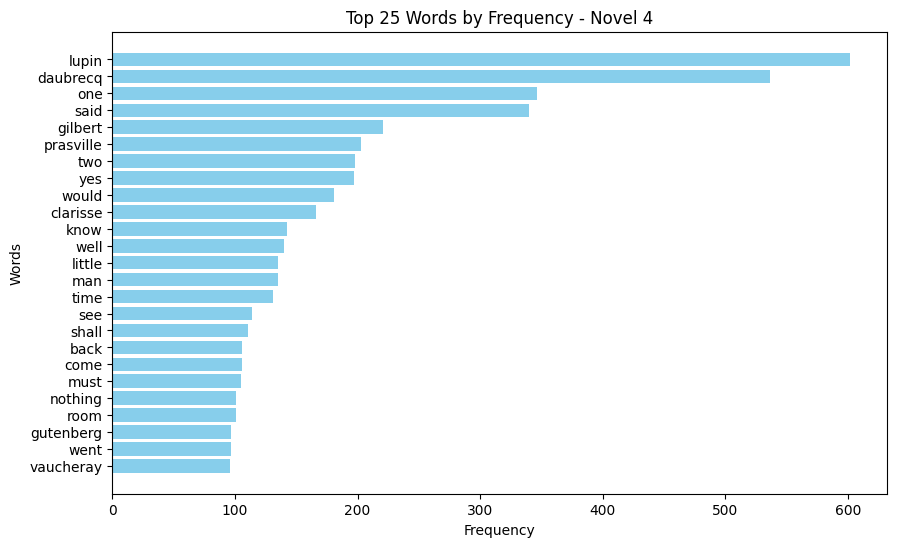

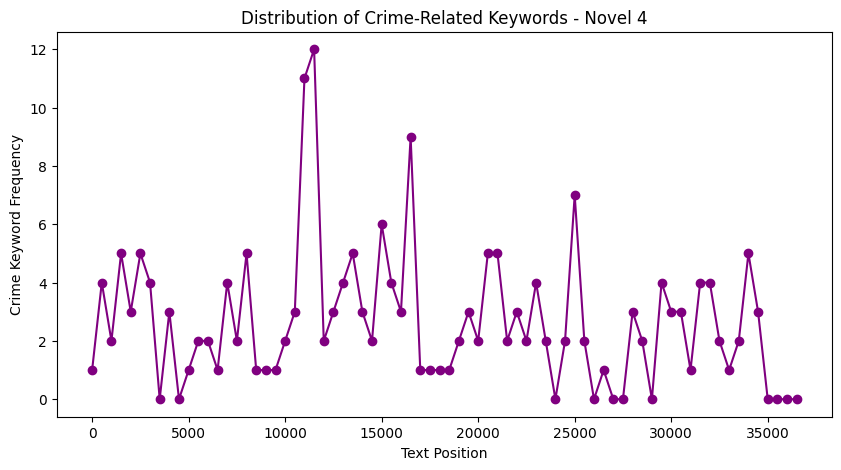

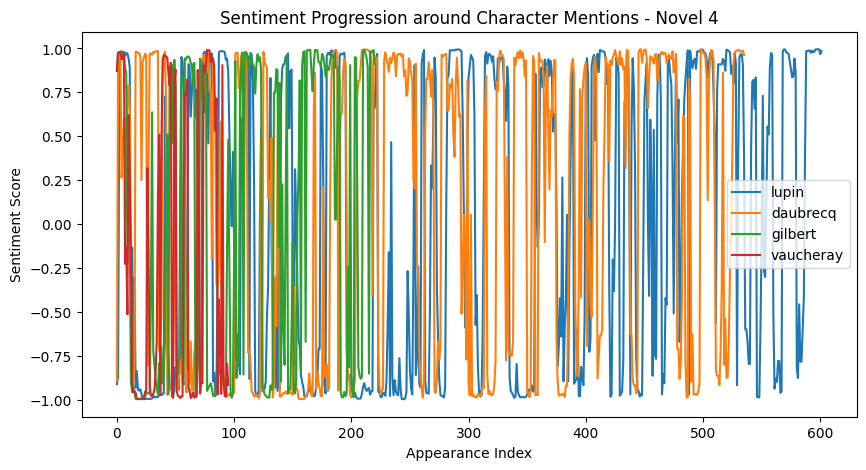

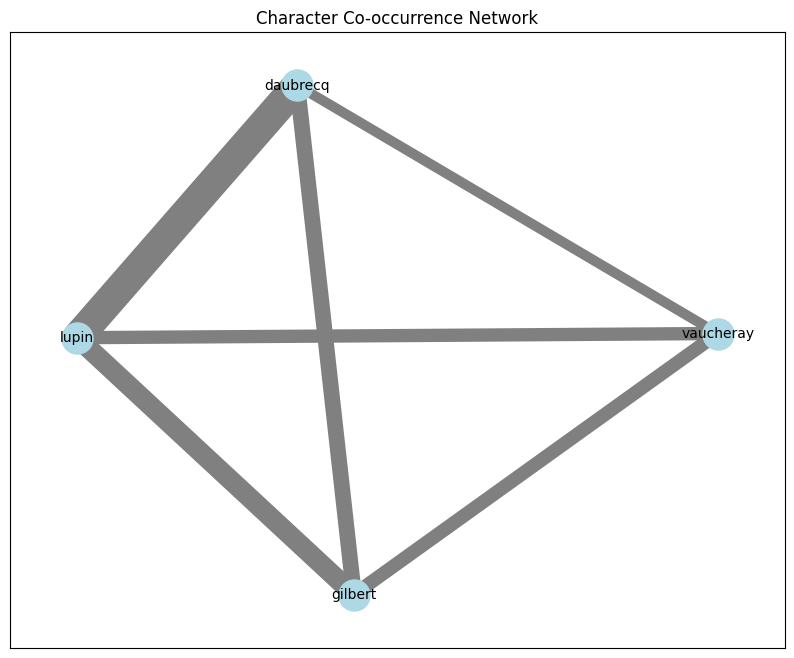

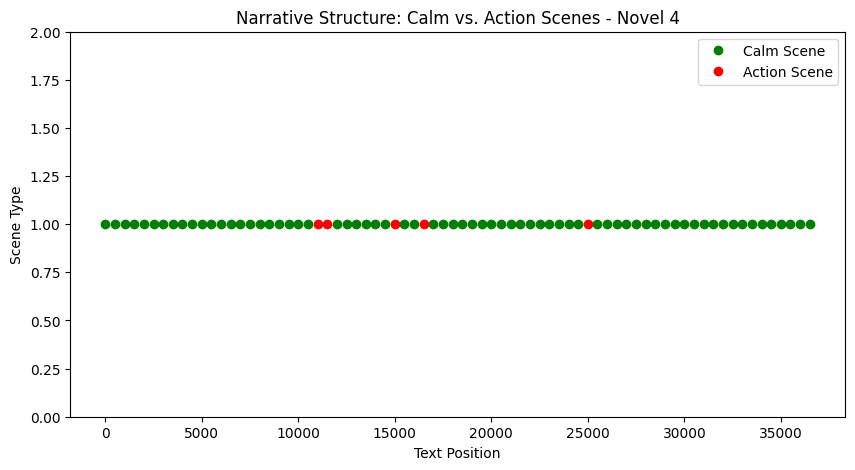

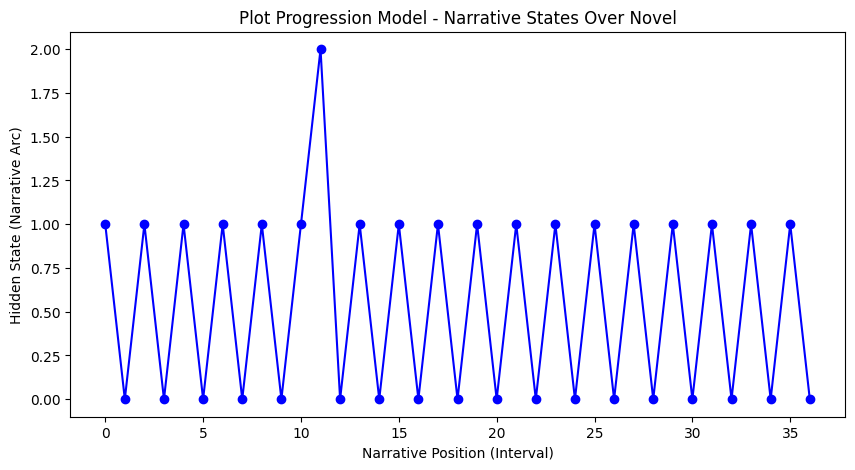

Processed and visualized data for Novel 4



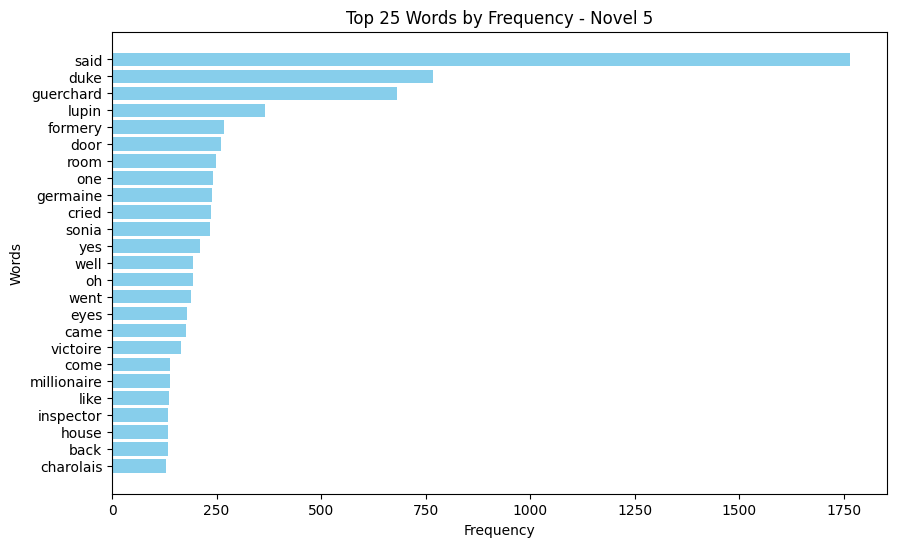

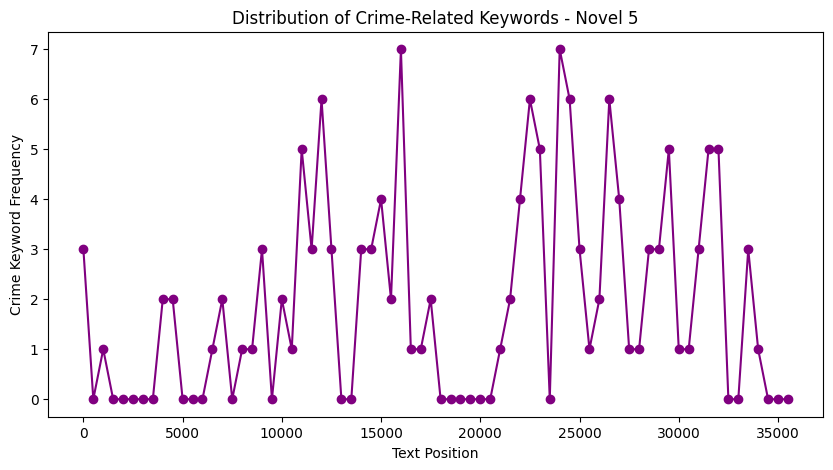

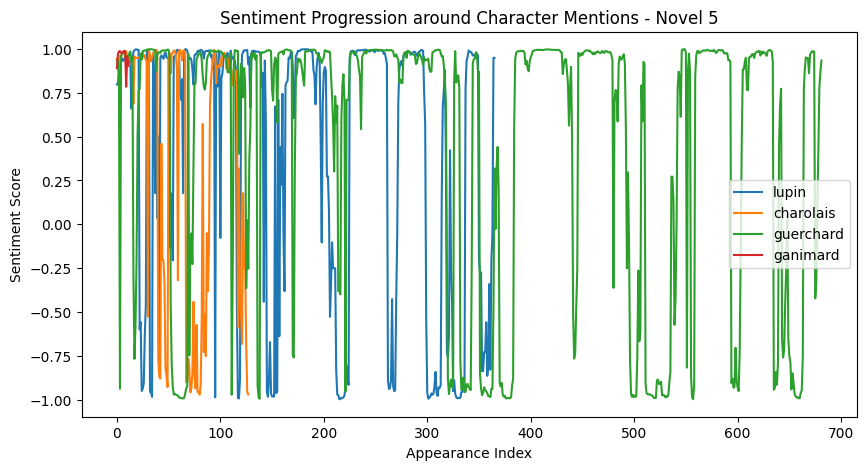

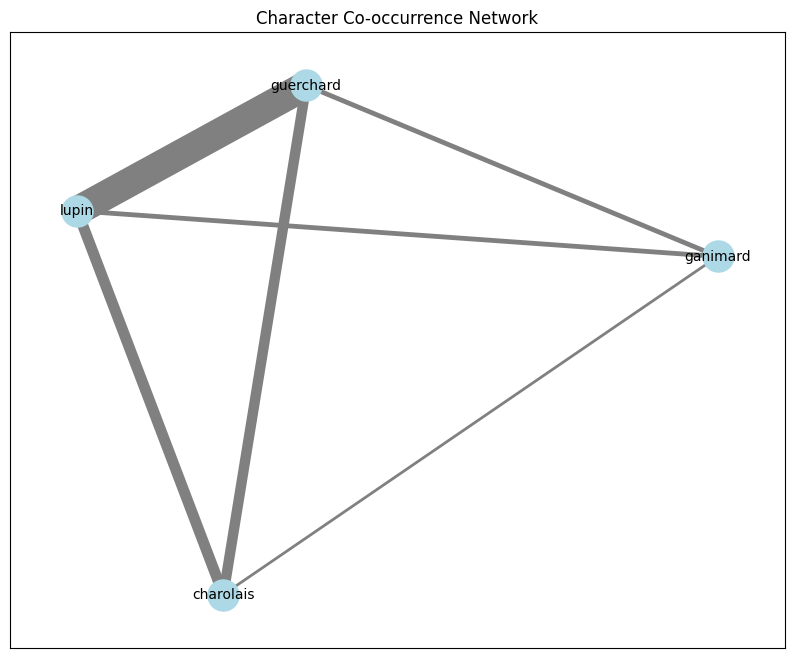

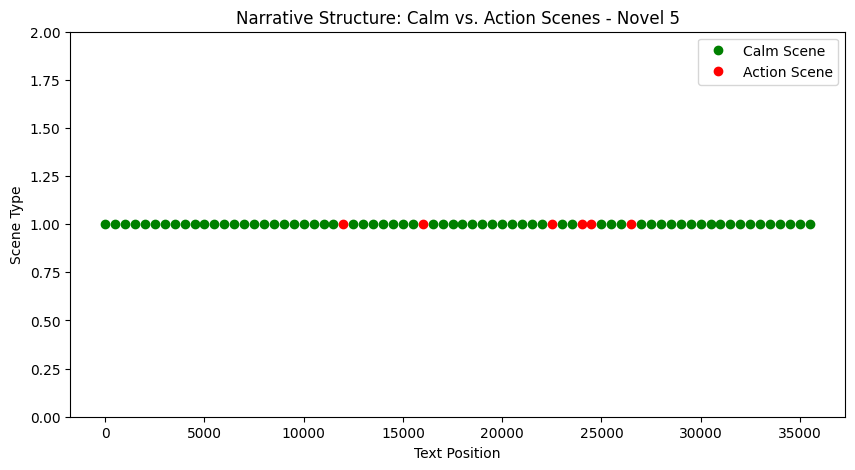

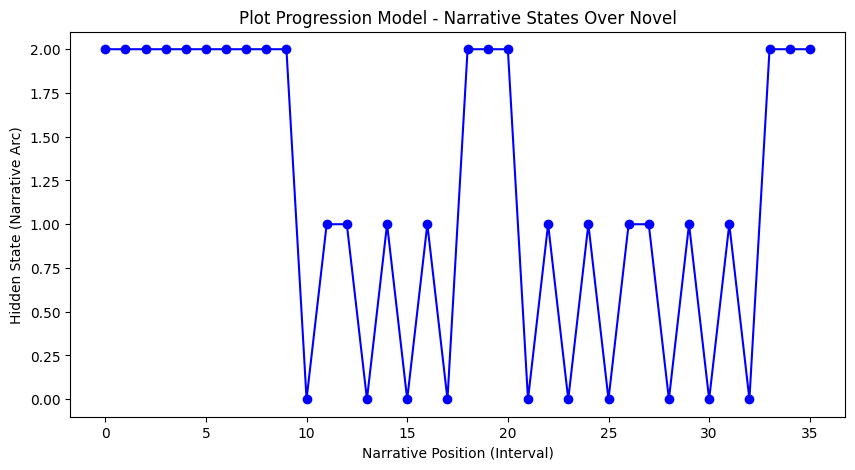

Processed and visualized data for Novel 5



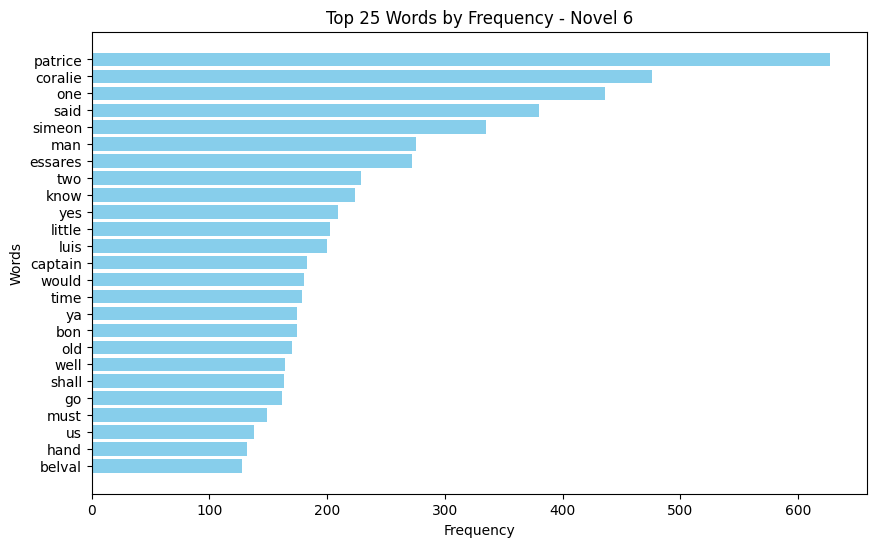

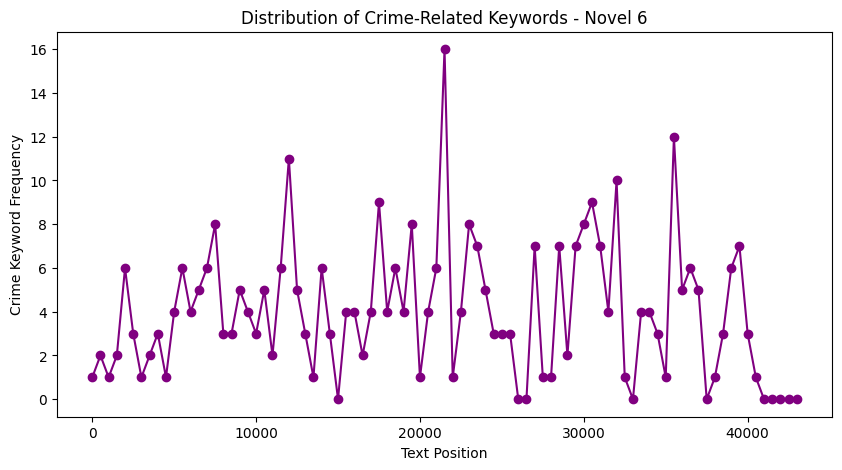

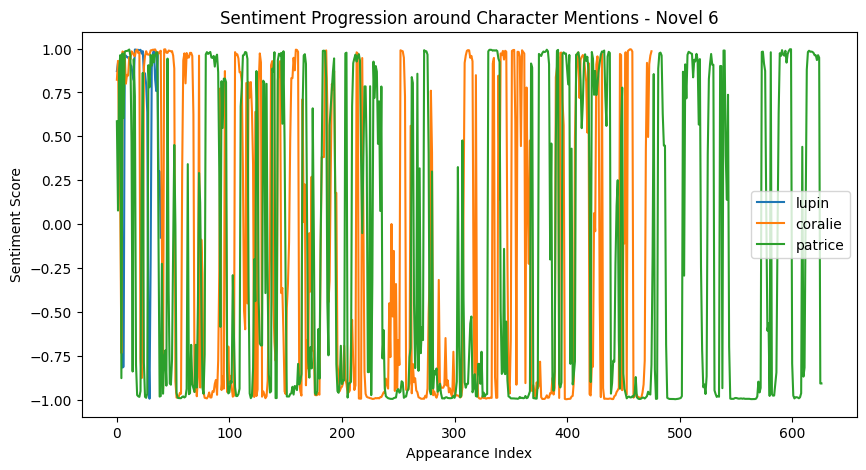

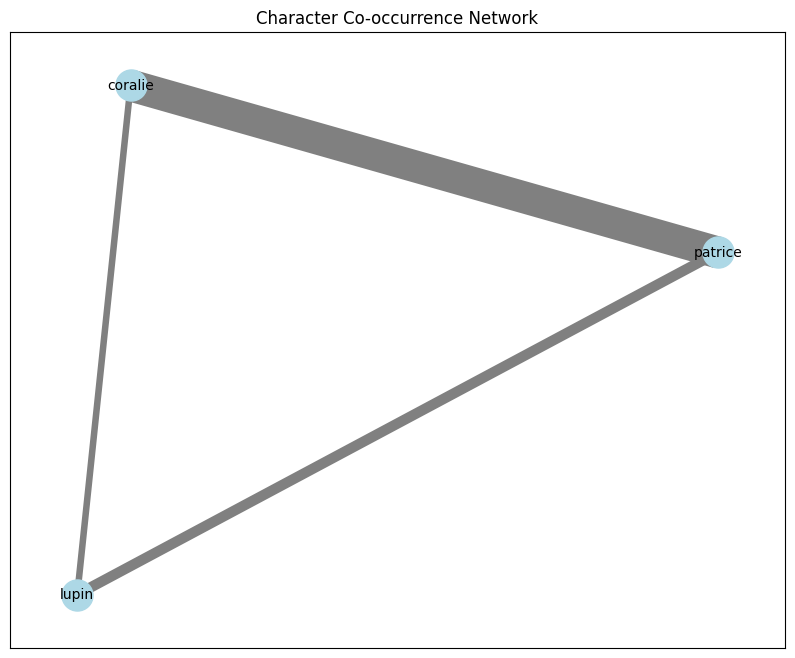

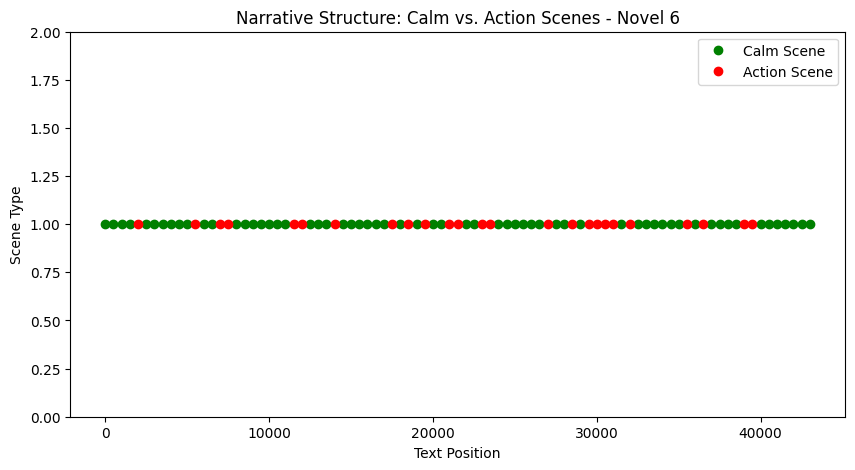

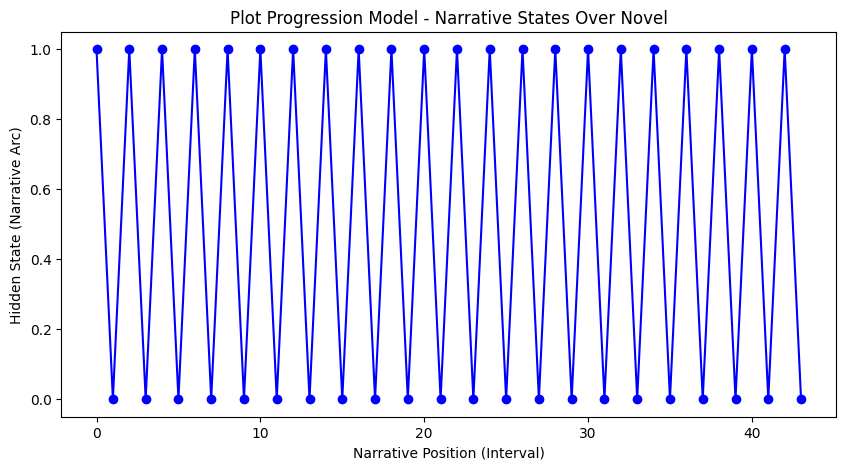

Processed and visualized data for Novel 6



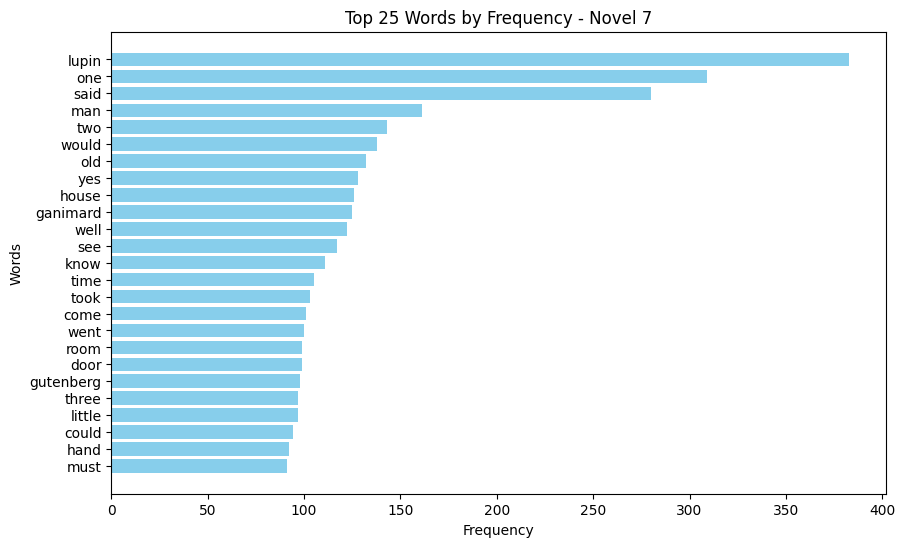

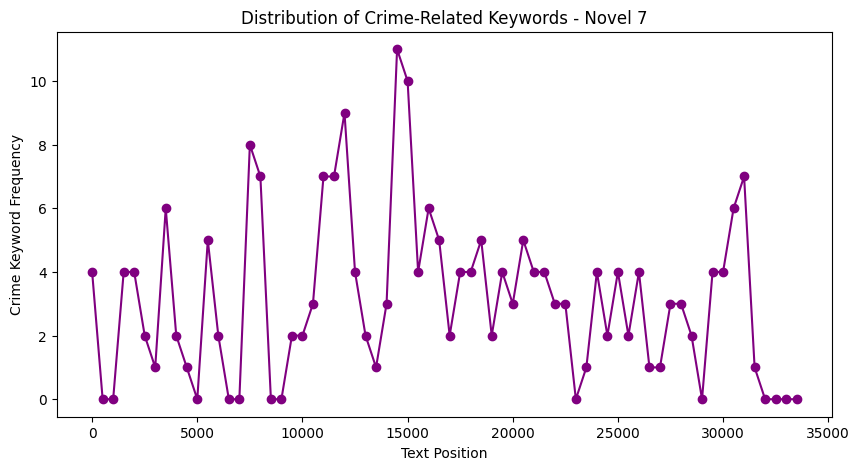

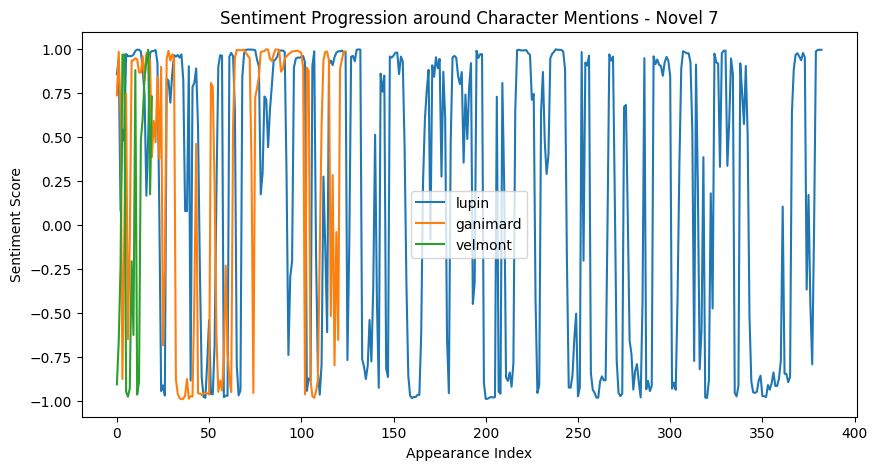

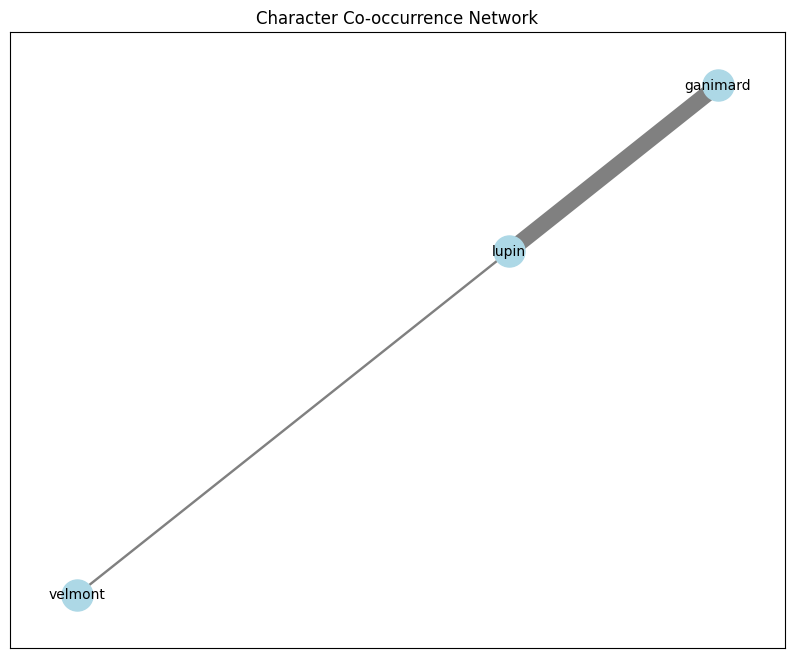

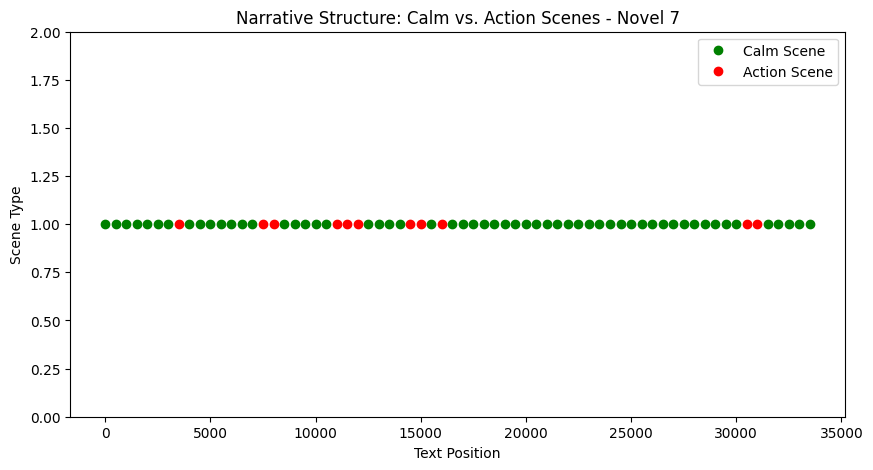

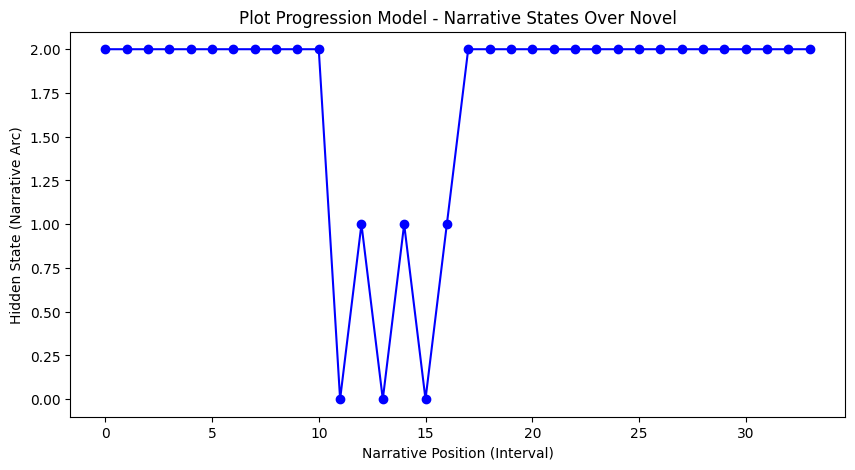

Processed and visualized data for Novel 7



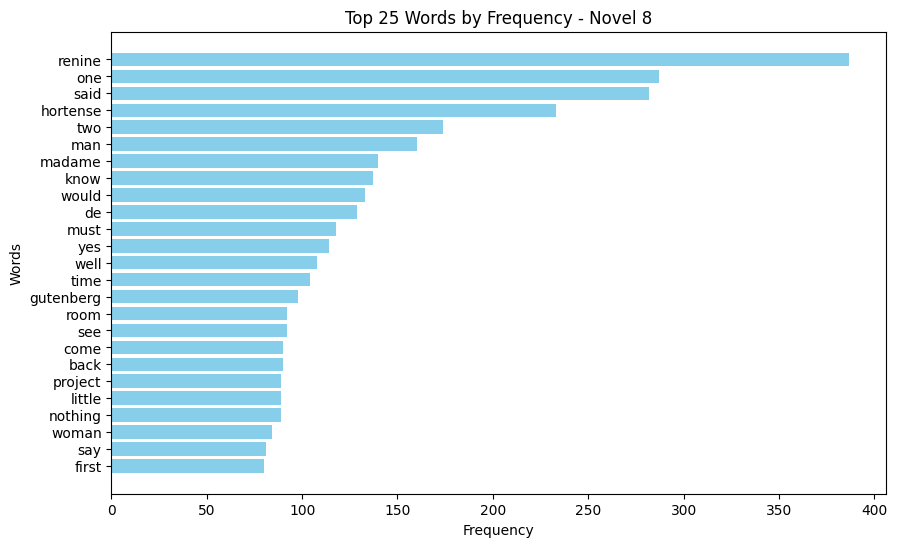

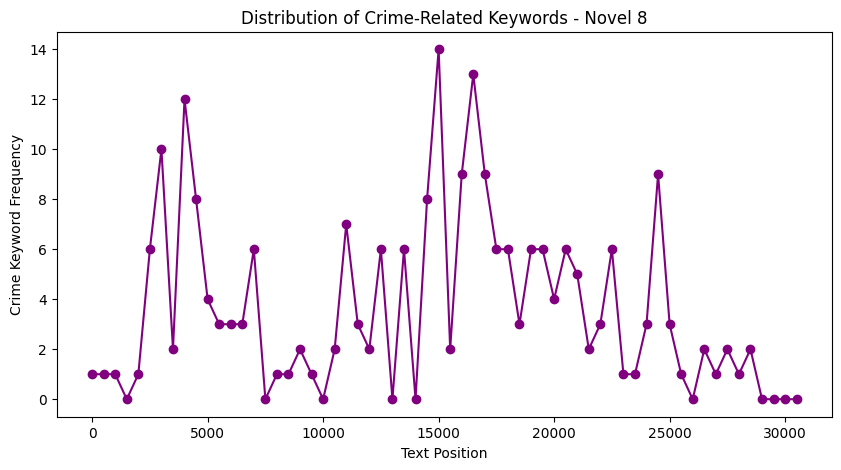

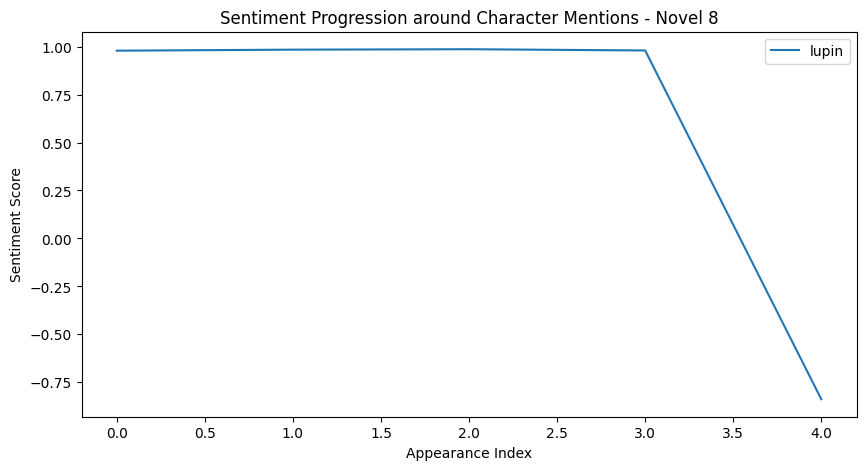

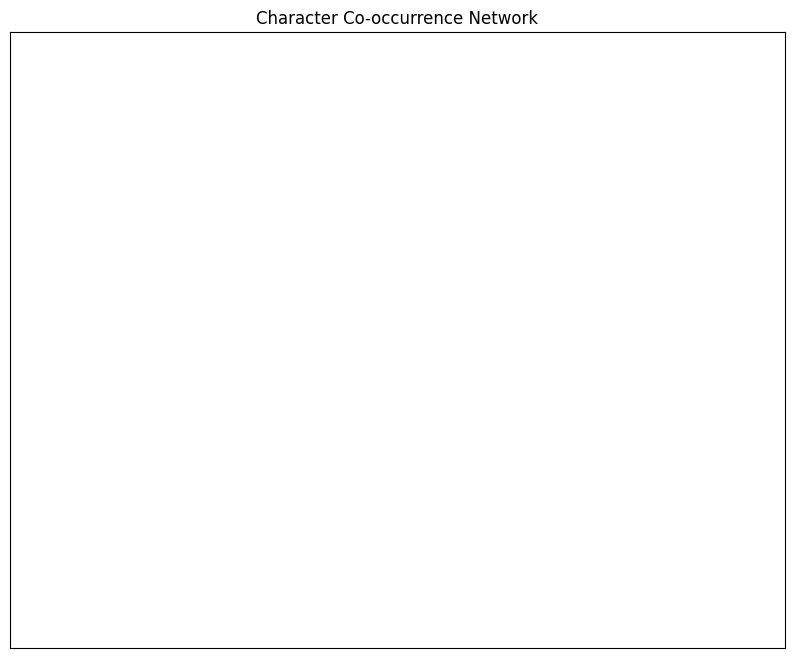

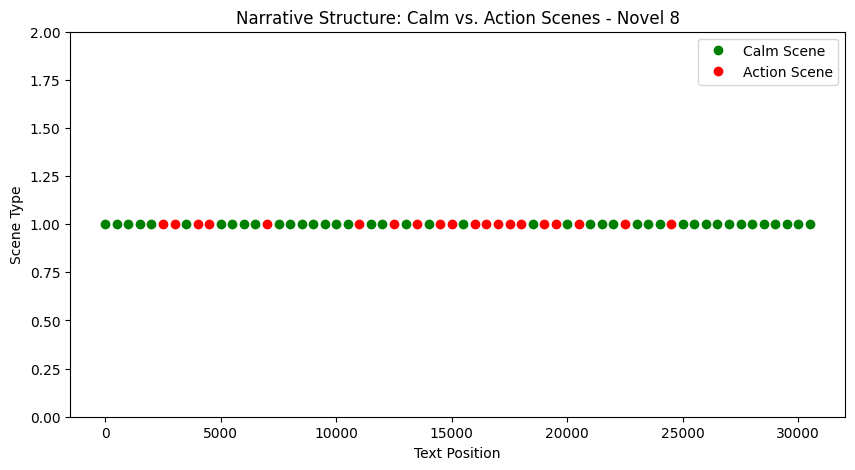

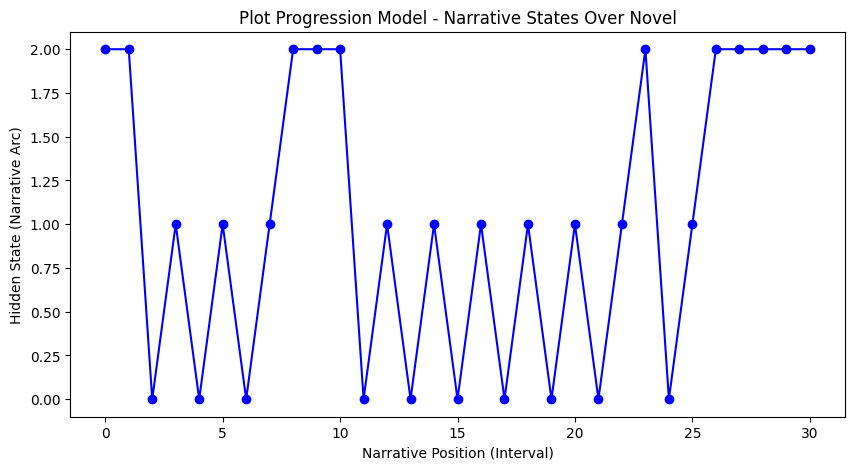

Processed and visualized data for Novel 8



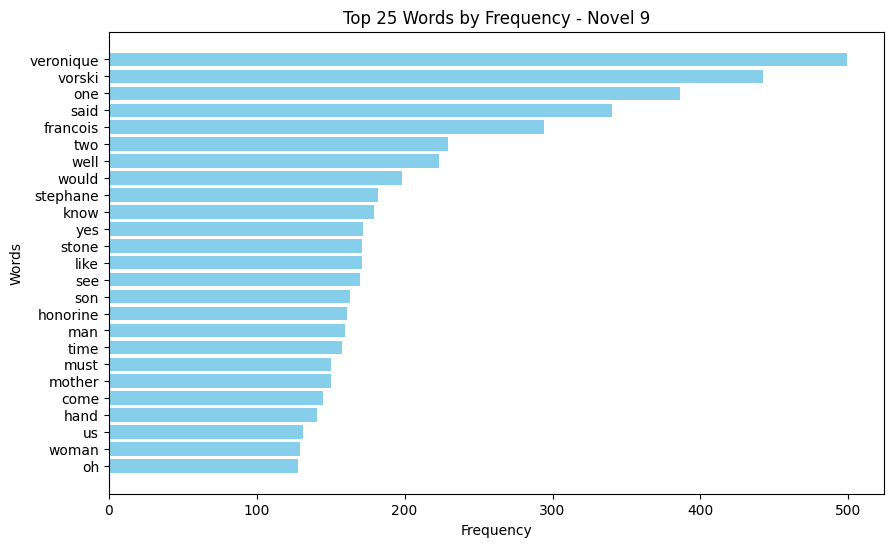

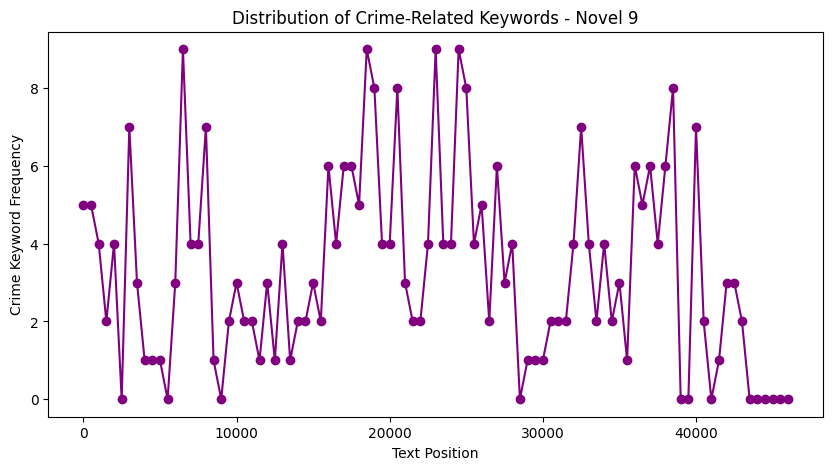

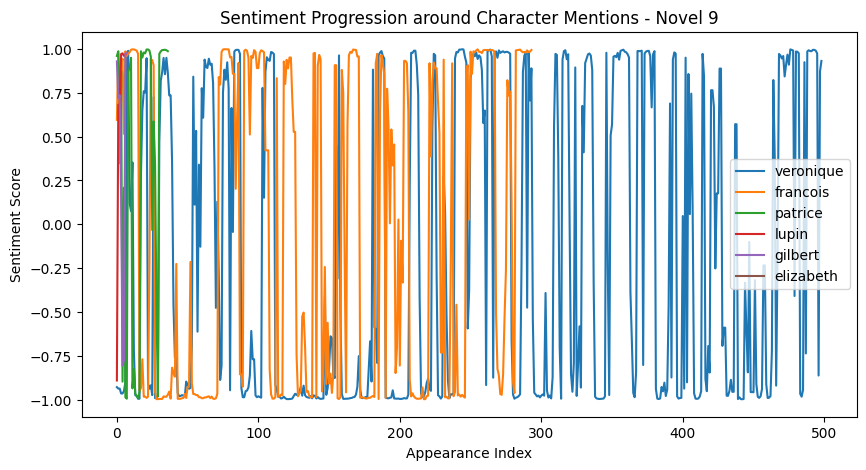

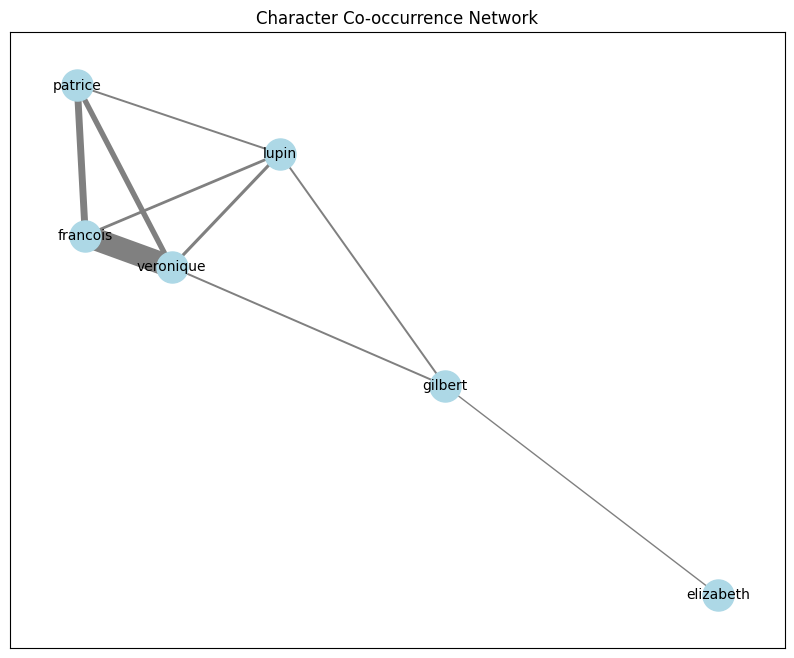

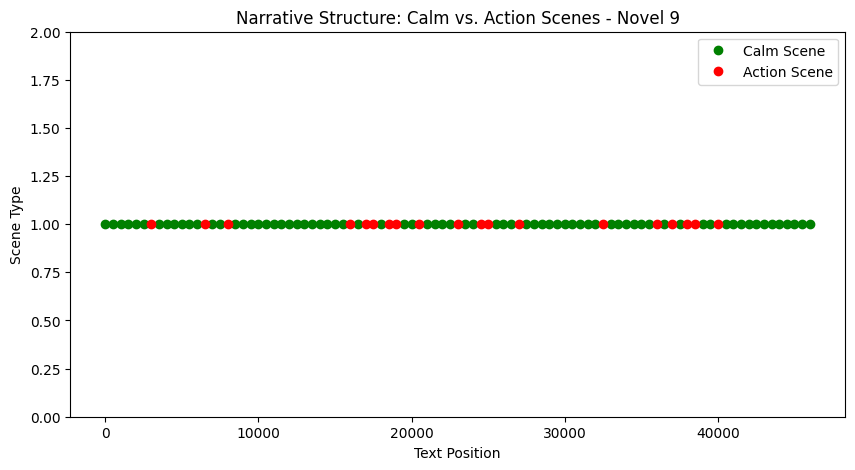

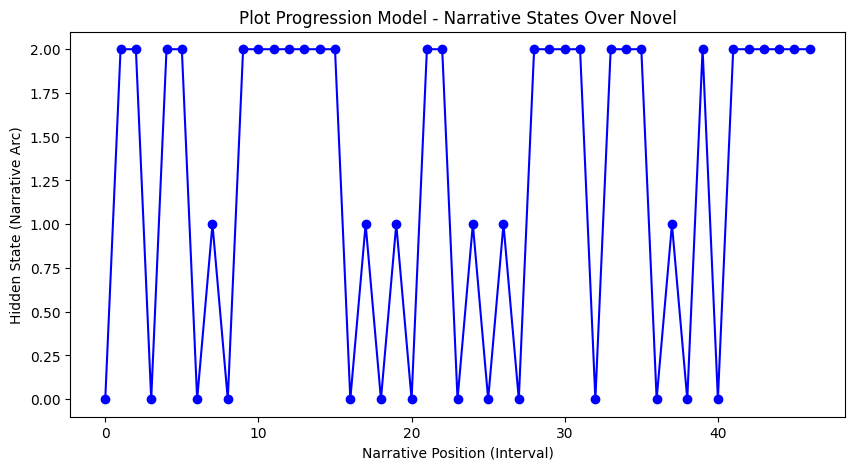

Processed and visualized data for Novel 9



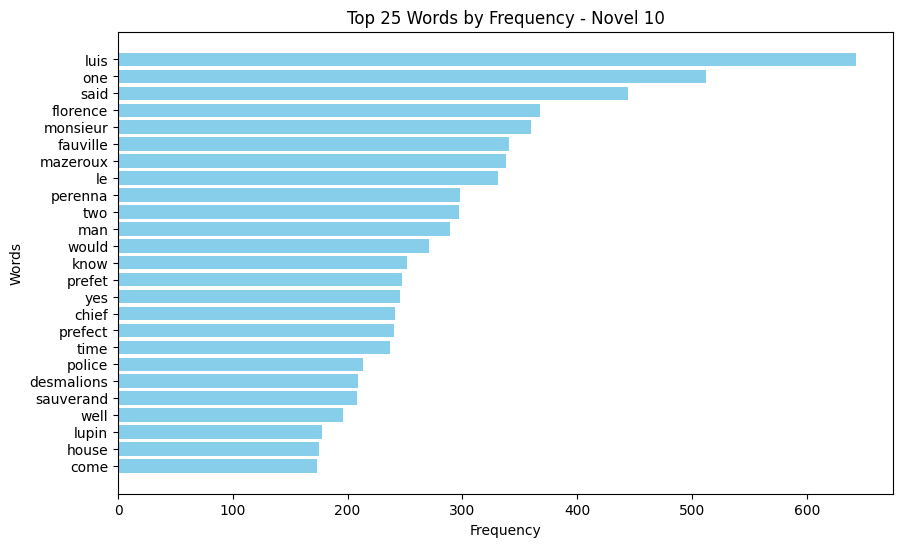

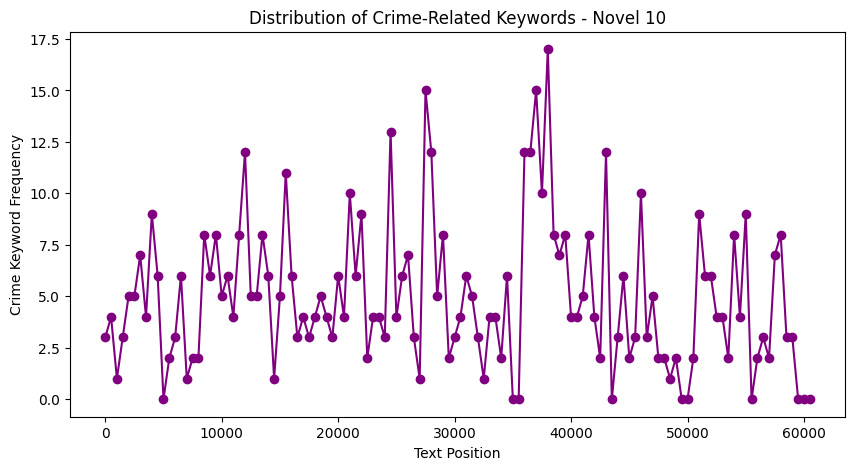

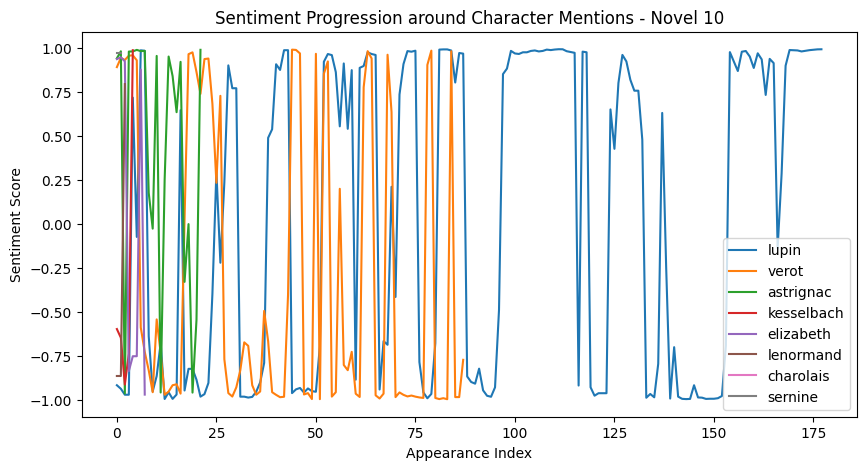

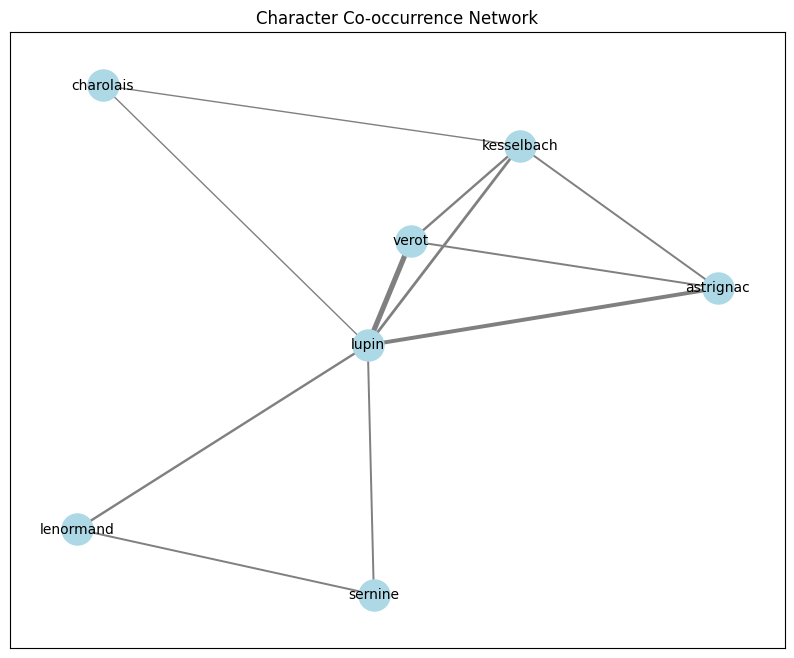

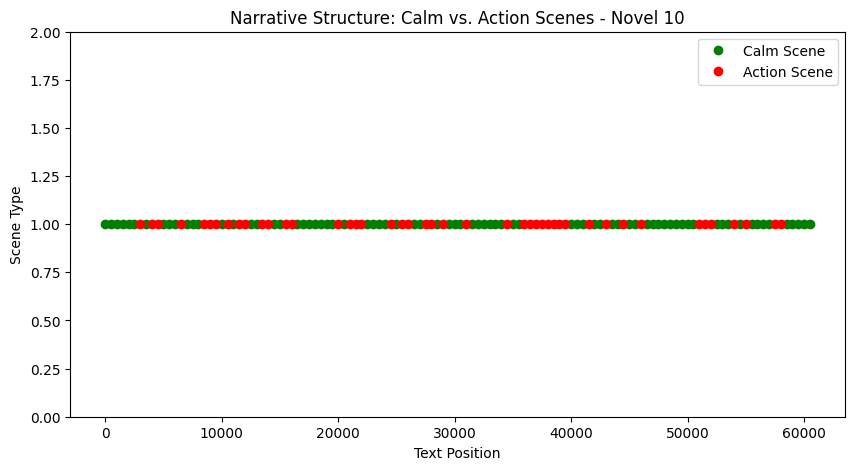

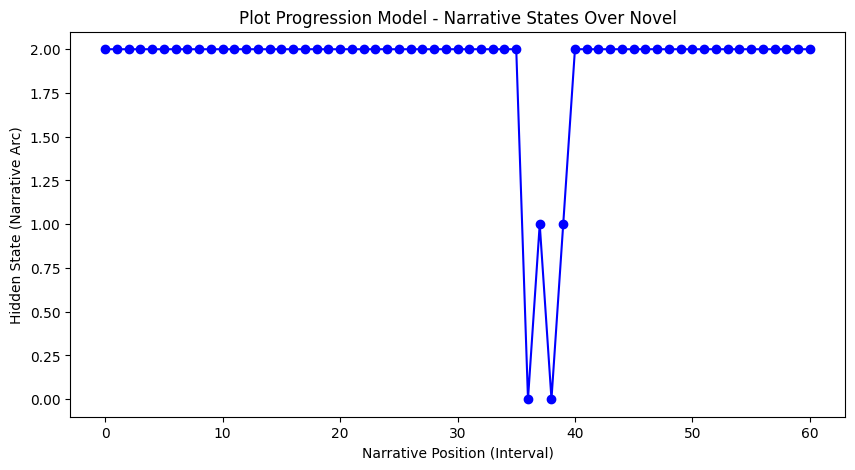

Processed and visualized data for Novel 10



In [94]:
# Initialize a combined co-occurrence dictionary for all novels
combined_co_occurrences = defaultdict(Counter)

# Process each novel and generate visualizations
for idx, url in enumerate(urls):
    # Download and preprocess each novel
    novel_text = download_novel(url)
    tokens = preprocess_text(novel_text)
    
    # Generate character-based features
    character_first_mentions, co_occurrences, character_sentiments = character_features(tokens, characters)
    
    # Accumulate co-occurrences for all novels
    for char1 in co_occurrences:
        for char2, count in co_occurrences[char1].items():
            combined_co_occurrences[char1][char2] += count
        
    # Generate event-based features
    first_crime_position, crime_keyword_counts, crime_adjectives = event_features(tokens, crime_keywords)
    
    # Crime keyword distribution
    crime_keyword_dist = crime_keyword_distribution(tokens, crime_keywords)
    
    # Structural features
    chapter_positions, calm_intervals, action_intervals = structural_features(tokens)
    
    # Visualization titles
    novel_title = f"Novel {idx + 1}"
    
    # Plot the top 25 words by frequency
    plot_top_words(tokens, title=novel_title)
    
    # Plot distribution of crime keywords
    plot_crime_keyword_distribution(crime_keyword_dist, title=novel_title)
    
    # Plot character sentiment progression
    plot_character_sentiments(character_sentiments, title=novel_title)

    # Plot co-occurrence network
    plot_character_network(co_occurrences)
    
    # Plot narrative structure
    plot_narrative_structure(calm_intervals, action_intervals, title=novel_title)

    # Generate features for plot progression model
    event_freq = plot_progression_features(tokens, crime_keywords)
    
    # Train and plot the plot progression model for this novel
    model, hidden_states = train_plot_progression_model(event_freq)

    print(f"Processed and visualized data for {novel_title}\n")

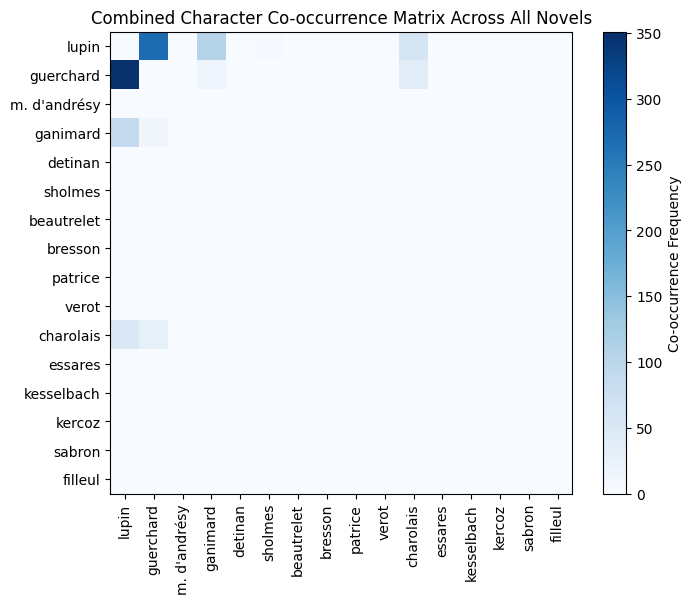

In [32]:
# Plot the combined co-occurrence matrix for all novels
plot_combined_co_occurrences(combined_co_occurrences, characters)

In [33]:
# Step 6: Perpetrator Prediction Model with Balanced Data
def prepare_perpetrator_data(character_first_mentions, co_occurrences, character_sentiments, character_sentiment_fluctuations, perpetrator="lupin"):
    data = []
    target = []
    
    for character, first_mention in character_first_mentions.items():
        if first_mention is not None:
            features = [
                first_mention,  # Position of first mention
                sum(co_occurrences[character].values()),  # Total interactions with other characters
                np.mean(character_sentiments[character]) if character_sentiments[character] else 0,  # Mean sentiment
                character_sentiment_fluctuations.get(character, 0)  # Sentiment fluctuation
            ]
            data.append(features)
            target.append(1 if character == perpetrator else 0)
    
    # Balance classes by adding synthetic samples for both perpetrator and non-perpetrator classes
    num_synthetic_samples = max(20, len(data) * 2)  # Aim for at least 20 samples per class

    # Add synthetic perpetrator samples if needed
    for _ in range(num_synthetic_samples - sum(1 for label in target if label == 1)):
        data.append([np.random.randint(100, 500), np.random.randint(1, 10), np.random.uniform(0.5, 1), np.random.uniform(0.2, 0.8)])
        target.append(1)  # Perpetrator class

    # Add synthetic non-perpetrator samples if needed
    for _ in range(num_synthetic_samples - sum(1 for label in target if label == 0)):
        data.append([np.random.randint(500, 1000), np.random.randint(1, 5), np.random.uniform(-1, 0.5), np.random.uniform(0, 0.5)])
        target.append(0)  # Non-perpetrator class

    X = np.array(data)
    y = np.array(target)
    print("Perpetrator data prepared with classes:", Counter(y))
    return X, y

# Model training and evaluation for perpetrator prediction using StratifiedKFold
try:
    X_perpetrator, y_perpetrator = prepare_perpetrator_data(
        character_first_mentions, co_occurrences, character_sentiments, defaultdict(float)
    )
    
    # Train Logistic Regression model with StratifiedKFold for class balance
    perpetrator_model = LogisticRegression()
    skf = StratifiedKFold(n_splits=2)

    # Evaluate with Stratified K-Fold
    scores = []
    for train_index, test_index in skf.split(X_perpetrator, y_perpetrator):
        X_train, X_test = X_perpetrator[train_index], X_perpetrator[test_index]
        y_train, y_test = y_perpetrator[train_index], y_perpetrator[test_index]
        perpetrator_model.fit(X_train, y_train)
        score = perpetrator_model.score(X_test, y_test)
        scores.append(score)
    
    print("Perpetrator Prediction Model - Stratified Cross-validation scores:", scores)
    print("Perpetrator Prediction Model - Mean accuracy:", np.mean(scores))

except ValueError as e:
    print("Error in preparing perpetrator data:", e)


Perpetrator data prepared with classes: Counter({1: 20, 0: 20})
Perpetrator Prediction Model - Stratified Cross-validation scores: [0.9, 1.0]
Perpetrator Prediction Model - Mean accuracy: 0.95
